In [3]:
import pymongo
import json
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

# --- For Radial Graph ---
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [4]:
with open('../config.json', 'r') as file:
    config = json.load(file)

mongo_uri = config['mongo_uri']
database_name = config['database_name']
softwares_collection = config['container_softwares']
machines_collection = config['container_machines']

In [5]:
client = pymongo.MongoClient(mongo_uri)
    
# Select the database
db = client[database_name]

# Collection for store software data
softwares_clt = db[softwares_collection]

# Collection for store machine data
machines_clt = db[machines_collection]

In [6]:
def get_vulnerable_softwares():
    """
    Get all softwares with vulnerabilities in the database
    Args: None
    Returns: A list of softwares with vulnerabilities    
    """
    vulnerable_softwares = softwares_clt.find({'vulnerabilities': {'$not': {'$size': 0}}}, {'_id': 0})
    return vulnerable_softwares

In [7]:
def impact_vulnerabilities(vulnerable_softwares):
    """
    Create a chart of horizontal bars with the impact of all vulnerabilities (low, medium, high, critical)
    Args: None
    Returns: None
    """
    impact = { 
              'UNKNOWN': 0,
              'LOW': 0,
              'MEDIUM': 0,
              'HIGH': 0,
              'CRITICAL': 0
              }
    for software in vulnerable_softwares:
        for vulnerability in software['vulnerabilities']:
            severity = "UNKNOWN"
            if 'baseSeverity' in vulnerability['metrics']:
                severity = vulnerability['metrics']['baseSeverity']
            if severity in impact:
                impact[severity] += 1
            else:
                impact[severity] += 1

                
    colors = ["#475387","#edc40c","#ed6d0c","#c90e0e","#111111"]
    
    for i, v in enumerate(list(impact.values())):
        plt.text(v + 5 , i, str(v), 
            color = '#1f6b46', fontweight = 'bold')
        
    plt.grid(True, zorder = 1)
    plt.barh(list(impact.keys()), list(impact.values()), color=colors, zorder = 2)
    plt.xlim(0, max(impact.values()) + 20)
    plt.xlabel('Number of vulnerabilities')
    plt.ylabel('Impact')
    plt.show()
            

In [8]:
def chart_top_ten_vulnerable_softwares():
    """
    Create a pie chart with the top ten softwares with more vulnerabilities
    the top ten softwares are sorted by the number of vulnerabilities and its calculated with 
    the field 'totalVulnerabilities' in the database
    The average number of vulnerabilities is represented with a dashed red line
    Args: None
    Returns: None
    """
    # get all softwares with vulnerabilities sorted by totalVulnerabilities field
    softwares_sorted = list(softwares_clt.find({'vulnerabilities': {'$not': {'$size': 0}}}, {'_id': 0}).sort('totalVulnerabilities', -1))
    top_softwares = softwares_sorted[:6]
    # create a json of a software with the rest of the softwares named 'Others' and the sum of their totalVulnerabilities
    # Then add this json to the list of top softwares
    others = {
            'name': 'Others',
            'totalVulnerabilities': sum([s['totalVulnerabilities'] for s in softwares_sorted[6:]])
            }
    top_softwares.append(others)
    
    names = [s['name'] for s in top_softwares]
    vulnerabilities = [s['totalVulnerabilities'] for s in top_softwares]
    colors = ["#1A237E","#0D47A1","#437ede","#004D40","#006064","#145417","#236927"]
   
    cmap = plt.get_cmap('Dark2')  # Choose a colormap
    colors = cmap(np.linspace(0, 1, len(top_softwares)))
   
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    explode = (0.1,0,0,0,0,0,0)
    wedges, texts, autotexts = ax.pie(vulnerabilities,shadow = True, labels=names,explode = explode, colors = colors, autopct='%1.1f%%',textprops = dict(color = "w"),pctdistance=0.75)
    ax.legend(wedges, names,
          title="Softwares",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight="bold")
    plt.show()
    
    

        

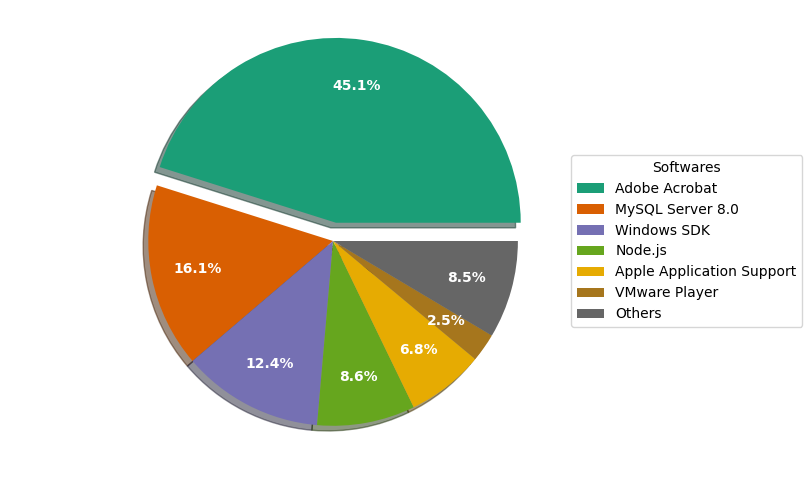

In [9]:
chart_top_ten_vulnerable_softwares()

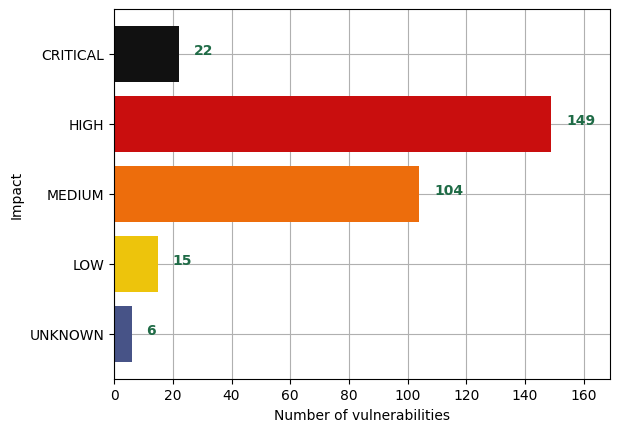

In [10]:
vulnerable_softwares = get_vulnerable_softwares()
impact_vulnerabilities(vulnerable_softwares)

In [11]:
def qty_critical_vulns(vulnerable_softwares):
    """
        Get the number of critical vulnerabilities
        For each vulnerability in a sofwares, check if the severity is critical
        in the field of the software ['vulnerabilities'][item_position]['metrics']['baseSeverity']
        Args: vulnerable_softwares (list): List of softwares with vulnerabilities
        Returns: Number of critical vulnerabilities
    """
    critical_vulns = 0
    for software in vulnerable_softwares:
        for vulnerability in software['vulnerabilities']:
            if 'baseSeverity' in vulnerability['metrics']:
                if vulnerability['metrics']['baseSeverity'] == 'CRITICAL':
                    critical_vulns += 1
                    
    return critical_vulns

In [12]:
def most_vulnerable_machine():
    """
        Get the machine with the most vulnerabilities
        First get a list with the id in machine JSON
        Then for each machine, get the number of softwares vulnerable with that id in the field list  associatedMachines
        Args: None
    """
    id_machines = []
    most_vulnerable_machine = {
        'id': 0,
        'hostname': "",
        'vuln_softwares_qty': 0
    }
    try:
        id_machines = machines_clt.find({}, {'_id':0,'id': 1, 'hostname': 1})
        for id in id_machines:
            vuln_softwares_qty = softwares_clt.count_documents({'associatedMachines': id['id'], 'vulnerabilities': {'$not': {'$size': 0}}})
            if vuln_softwares_qty > most_vulnerable_machine['vuln_softwares_qty']:
                most_vulnerable_machine['id'] = id['id']
                most_vulnerable_machine['vuln_softwares_qty'] = vuln_softwares_qty
                most_vulnerable_machine['hostname'] = id['hostname']
    except Exception as e:
        print("Error getting the id machines list",e)
        
    return most_vulnerable_machine

In [13]:
print(json.dumps(most_vulnerable_machine(),indent=2))

{
  "id": "28c8e3cb-0938-429e-b4ce-24039d949df4",
  "hostname": "LAPTOP-HH71NAS7",
  "vuln_softwares_qty": 19
}


In [14]:
def recent_vulnerabilities_qty(current_year):
    """
        Get the number of vulnerabilities in the current year (2024)
        For each vulnerability in a sofwares, check if the CVE ID contains the current year
        Args: current_year (str): Current year
        Returns: Quantity of vulnerabilities in the current year
    """
    if current_year == None:
        return 0
    current_year = current_year.strip()
    if len(current_year) != 4:
        return 0
    
    recent_vulns = 0
    try:
        #software list with vulnerabilities that have been published in the current year
        softwares = list(softwares_clt.find({'vulnerabilities.CVE_ID': {'$regex': current_year}}, {'_id': 0, 'vulnerabilities': 1}))
        for software in softwares:
            for vulnerability in software['vulnerabilities']:
                if current_year in vulnerability['CVE_ID']:
                    recent_vulns += 1
    except Exception as e:
        print("Error getting the recent vulnerabilities",e)
        
    return recent_vulns

In [15]:
print(recent_vulnerabilities_qty("2024"))

55


In [16]:
def chart_top_ten_riskiest_vulnerabilities():
    """
    Create a chart of three vertical bars by vulnerability with the top ten vulnerabilities with more base score.
    The first bar is the base score, the second is exploitablity score and the third is impact score
    First get only the vulnerability list of all softwares with vulnerabilities, in this list the JSON have only
    four fields: baseScore, exploitabilityScore, impactScore and CVE_ID
    after that the functiont will create a unique list of vulnerabilities and sort by base score, by exploitability score and by impact score
    
    Args: None
    Returns: None
    """
    vulns_shorted_list = []
    try:
        vulns_list = list(softwares_clt.find({'vulnerabilities': {'$not': {'$size': 0}}},{'_id': 0, 'vulnerabilities': 1}))
    except Exception as e:
        print("Error getting the vulnerabilities list ",e)
        return
    
    for vulns in vulns_list:
        if not 'vulnerabilities' in vulns:
            continue
        for vuln in vulns['vulnerabilities']:
            baseScore = vuln['metrics']['baseScore'] if 'baseScore' in vuln['metrics'] else 0
            exploitabilityScore = vuln['metrics']['exploitabilityScore'] if 'exploitabilityScore' in vuln['metrics'] else 0
            impactScore = vuln['metrics']['impactScore'] if 'impactScore' in vuln['metrics'] else 0
            vulnShortedJSON = {
                'CVE_ID': vuln['CVE_ID'],
                'baseScore': baseScore,
                'exploitabilityScore': exploitabilityScore,
                'impactScore': impactScore,
            }
            vulns_shorted_list.append(vulnShortedJSON)
    vulns_shorted_list.sort(key=lambda x: (x['baseScore'], x['impactScore'], x['exploitabilityScore']), reverse=True)
    top_ten_vulns = vulns_shorted_list[:10]
    # Create the chart specified in the function description
    cve_ids = [vuln['CVE_ID'] for vuln in top_ten_vulns]
    base_scores = [vuln['baseScore'] for vuln in top_ten_vulns]
    exploitability_scores = [vuln['exploitabilityScore'] for vuln in top_ten_vulns]
    impact_scores = [vuln['impactScore'] for vuln in top_ten_vulns]
    X_axis = np.arange(len(top_ten_vulns)) 
  
  
    plt.figure(figsize=(12, 6))
    plt.bar(X_axis - 0.4, base_scores, width=0.4, label = 'Base Score', color = '#d00000')
    plt.bar(X_axis - 0.2, impact_scores, width=0.4, label = 'Impact Score', color = '#e85d04')  
    plt.bar(X_axis, exploitability_scores, width=0.4, label = 'Explotability Score', color = '#ffba08') 
    
    plt.ylim(0, 13)  
    plt.yticks(range(1, 13, 1))
    plt.xticks(X_axis-0.3, cve_ids,rotation=45, fontname = 'Arial', fontsize = 10) 
    plt.xlabel("CVE IDENTIFIER", fontsize = 12, fontweight = 'bold',fontname = 'Ms Gothic') 
    plt.ylabel("SCORE", fontsize = 12, fontweight = 'bold',fontname = 'Ms Gothic') 
    plt.legend() 
    
    plt.show() 
    
    
    

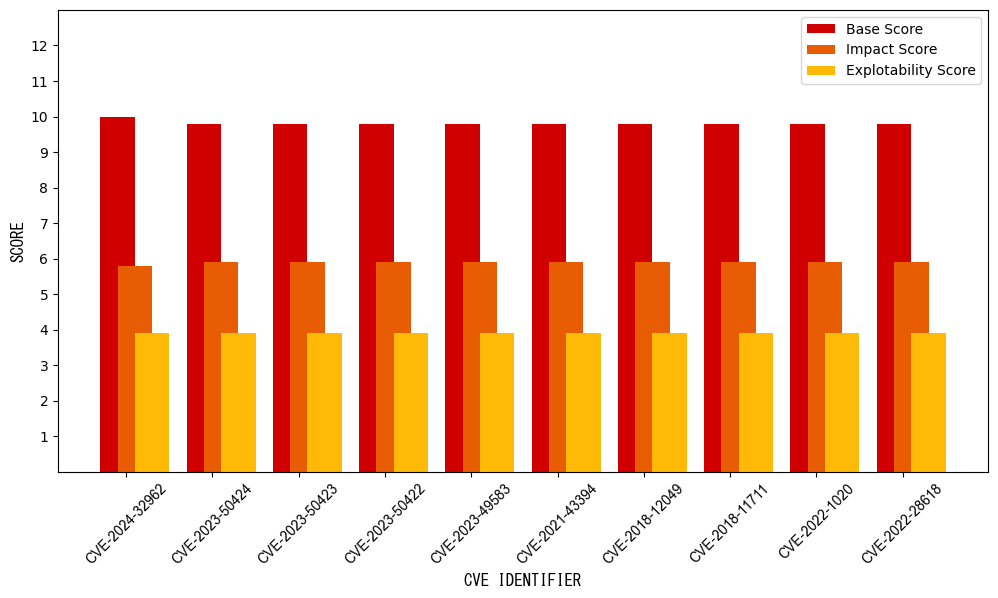

In [17]:
chart_top_ten_riskiest_vulnerabilities()

In [18]:
def qty_vulns_severity_across_time(vulnerable_softwares):
    """
    Create a chart with the number of vulnerabilities by severity across time
    this function, creates a six lists:
    - list of years: the year is obtained from CVE ID in the field ['vulnerabilities'][item_position]['CVE_ID']
    - list of low vulnerabilities: this contains the quantity of low vulnerabilities by year
    - list of medium vulnerabilities: this contains the quantity of medium vulnerabilities by year
    - list of high vulnerabilities: this contains the quantity of high vulnerabilities by year
    - list of critical vulnerabilities: this contains the quantity of critical vulnerabilities by year
    Second, the function creates a chart with the six lists created before 
    where x axis is the year and y axis is the other lists
    """
    
    # Lists to store the data
    years = []
    low_vulns = []
    medium_vulns = []
    high_vulns = []
    critical_vulns = []
    total_vulns = []
    
    # Get the data
    for software in vulnerable_softwares:
        if 'vulnerabilities' not in software:
            continue
        for vulnerability in software['vulnerabilities']:
            if 'baseSeverity' in vulnerability['metrics']:
                severity = vulnerability['metrics']['baseSeverity'] if 'baseSeverity' in vulnerability['metrics'] else 'UNKNOWN'
                year = vulnerability['CVE_ID'].split('-')[1]
                
                # Check if the year is already in the list, if not, add it
                if year not in years:
                    years.append(year)
                    low_vulns.append(0)
                    medium_vulns.append(0)
                    high_vulns.append(0)
                    critical_vulns.append(0)
                    total_vulns.append(0)
                years.sort()
                # Get the index of the year in the list
                year_index = years.index(year)
                total_vulns[year_index] += 1
                # Add the vulnerability to the corresponding list
                if severity == 'LOW':
                    low_vulns[year_index] += 1
                elif severity == 'MEDIUM':
                    medium_vulns[year_index] += 1
                elif severity == 'HIGH':
                    high_vulns[year_index] += 1
                elif severity == 'CRITICAL':
                    critical_vulns[year_index] += 1    
    
    # Create the chart
    plt.figure(figsize=(10, 6))
    # set background color gray
    plt.gca().set_facecolor('#EEEEEE')
    plt.plot(years, low_vulns, label='Low', color='#e3d800' , linewidth = 2, zorder = 2, marker = 'o', markersize = 4)
    plt.plot(years, medium_vulns, label='Medium', color='orange', linewidth = 2, zorder = 2, marker = 'o', markersize = 4)
    plt.plot(years, high_vulns, label='High', color='red', linewidth = 2, zorder = 2, marker = 'o', markersize = 4)
    plt.plot(years, critical_vulns, label='Critical', color='black', linewidth = 2, zorder = 2, marker = 'o', markersize = 4)
    plt.grid(True, zorder = 3)
    plt.legend()
    plt.yticks(range(0, max(high_vulns)+2, 2))
    plt.xlabel('Year')
    plt.xticks(rotation=45)
    plt.ylabel('Number of vulnerabilities')
    plt.show()                 

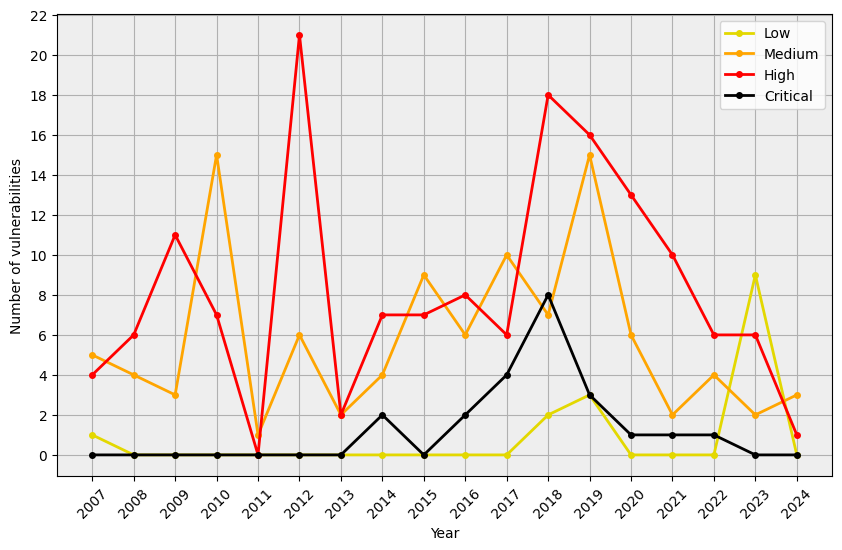

In [19]:
vulnerable_softwares = get_vulnerable_softwares()
qty_vulns_severity_across_time(vulnerable_softwares)

In [20]:
def donut_chart_machines_most_vuln():
    """
        Create a donut chart with the machines with the most vulnerabilities
        The first six machines with more vulnerabilities are selected for normal percentage
        and the rest of the machines are grouped in a single slice called 'Others'
    """
    list_machines = []
    try:
        id_machines = machines_clt.find({}, {'_id':0,'id':1,'hostname': 1})
        for id in id_machines:
            vuln_softwares_qty = softwares_clt.count_documents({'associatedMachines': id['id'], 'vulnerabilities': {'$not': {'$size': 0}}})
            list_machines.append(
                {
                    'id': id['id'],
                    'hostname': id['hostname'], 
                    'vuln_softwares_qty': vuln_softwares_qty
                }
            )
    except Exception as e:
        print("Error getting the id machines list",e)
        return
    
    list_machines.sort(key=lambda x: x['vuln_softwares_qty'], reverse=True)
    top_machines = list_machines[:9]
    others = {
        'id': 0,
        'hostname': 'Others',
        'vuln_softwares_qty': sum([m['vuln_softwares_qty'] for m in list_machines[9:]])
    }
    top_machines.append(others)
    hostnames = [m['hostname'] for m in top_machines]
    vulnerabilities = [m['vuln_softwares_qty'] for m in top_machines]
    
    colors = ["#4a148c","#311b92","#1A237E","#0D47A1","#437ede","#006064","#1b4332","#145417","#236927","#55a630"]
        
    fig, (ax,ax2) = plt.subplots(1, 2, figsize=(9, 5), gridspec_kw={'width_ratios': [3, 1]})
    explode = (0.2,0,0,0,0,0,0,0,0,0)
    
    def absolute_value(val):
        a  = np.round(val/100.*np.sum(vulnerabilities), 0)
        return int(a)
    
    wedges, texts, autotexts = ax.pie(
        vulnerabilities,shadow = True, labels=hostnames,explode = explode, colors = colors, autopct=absolute_value,
        textprops = dict(color = "w"),pctdistance=0.8, startangle=-30, wedgeprops=dict(width=0.6, edgecolor='black')
        )
    ax.legend(wedges, hostnames,
        title="Machines",
        loc="upper center",
        bbox_to_anchor=(1,0.8, -2.7, 0))
    
    # create a bar percentage chart with the severities (low, medium, high, critical) of the vulnerabilities in the softwares
    # with the first machine in the list
    vuln_softwares = list(softwares_clt.find({'associatedMachines': top_machines[0]['id'], 'vulnerabilities': {'$not': {'$size': 0}}}, {'_id': 0, 'vulnerabilities': 1}))
    impact = { 
              'LOW': 0,
              'MEDIUM': 0,
              'HIGH': 0,
              'CRITICAL': 0
              }
    for software in vuln_softwares:
        if 'vulnerabilities' not in software:
            continue
        for vulnerability in software['vulnerabilities']:
            severity = "UNKNOWN"
            if 'baseSeverity' in vulnerability['metrics']:
                severity = vulnerability['metrics']['baseSeverity']
            
            if severity in impact:
                impact[severity] += 1
    print(impact)
    impact_values = list(impact.values())
    impact_values = [(v/sum(impact_values)*100)/100 for v in impact_values]
    impact_names = list(impact.keys())
    impact_values.reverse()
    impact_names.reverse()
    
    severity_colors = ["#111111","#c90e0e","#ed6d0c","#edc40c"]
    
    bottom = 0
    width = 0.20 
    
    for j, (height, label) in enumerate(zip(impact_values, impact_names)):
        if j == 3:
            bc = ax2.bar(0, height+0.1, width, bottom=bottom, color=severity_colors[j], label=label, linewidth=1, edgecolor='black')
        else:
            bc = ax2.bar(0, height, width, bottom=bottom, color=severity_colors[j], label=label, linewidth=1, edgecolor='black')
        ax2.bar_label(bc, labels=[f"{height:.1%}"], label_type='center', color='white', fontsize=10, fontweight='bold')
        bottom += height   
        
    ax2.legend(loc="lower left", bbox_to_anchor=(0.8,0.4), ncol=1, fontsize=10)   
    ax2.axis('off')
    ax2.set_xlim(- 1.5 * width, 1.5 * width)
    
    # use ConnectionPatch to draw lines between the two plots
    theta1, theta2 = wedges[0].theta1, wedges[0].theta2
    center, r = wedges[0].center, wedges[0].r
    bar_height = sum(impact_values)

    # draw top connecting line
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = r * np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, bar_height+0.1), coordsA=ax2.transData,
                        xyB=(x, y), coordsB=ax.transData)
    con.set_color('#111111')
    con.set_linewidth(2)
    ax2.add_artist(con)

    # draw bottom connecting line
    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = r * np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                        xyB=(x, y), coordsB=ax.transData)
    con.set_color('#111111')
    ax2.add_artist(con)
    con.set_linewidth(2)
    
    plt.setp(autotexts, size=10, weight="bold")
    plt.show()
    

{'LOW': 2, 'MEDIUM': 26, 'HIGH': 55, 'CRITICAL': 10}


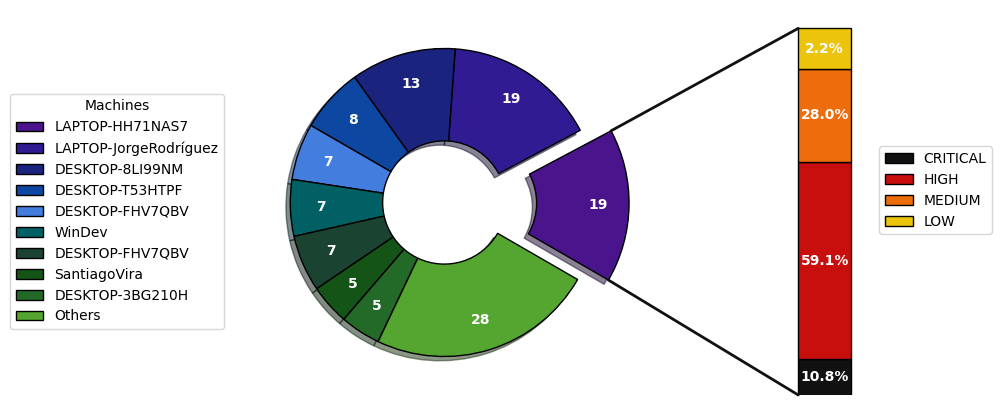

In [21]:
donut_chart_machines_most_vuln()

In [22]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [23]:
def radial_chart_cves_version3():
    """ 
        Create a radial chart with all the vulnerabilities that have a CVSS version 3.0 or 3.1
        The radial chart is a octogon with the following values:
        - 1: Attack Vector, possible values: Network (0.8), Adjacent (0.6), Local (0.4), Physical (0.2)
        - 2: Attack Complexity, possible values: Low (0.8), High (0.4)
        - 3: Privileges Required, possible values: None (0.8), Low (0.6), High (0.4)
        - 4: User Interaction, possible values: None (0.85), Required (0.25)
        - 5: Scope, possible values: Unchanged (0.85), Changed (0.25)
        - 6: Confidentiality Impact, possible values: None (0.0), Low (0.4), High (0.8)
        - 7: Integrity Impact, possible values: None (0.0), Low (0.4), High (0.8)
        - 8: Availability Impact, possible values: None (0.0), Low (0.4), High (0.8)
        
        The radial chart has 4 r grids (0.2, 0.4, 0.6, 0.8) 
    """
    values = {
        "attack_vector": {
            'NETWORK': 0.8,
            'ADJACENT': 0.6,
            'LOCAL': 0.4,
            'PHYSICAL': 0.2
        },
        "attack_complexity": {
            'LOW': 0.8,
            'HIGH': 0.4
        },
        "privileges_required": {
            'NONE': 0.8,
            'LOW': 0.6,
            'HIGH': 0.4
        },
        "user_interaction": {
            'NONE': 0.85,
            'REQUIRED': 0.25
        },
        "scope": {
            'UNCHANGED': 0.85,
            'CHANGED': 0.25
        },
        "confidentiality_impact": {
            'NONE': 0.0,
            'LOW': 0.3,
            'HIGH': 0.6
        },
        "integrity_impact": {
            'NONE': 0.0,
            'LOW': 0.3,
            'HIGH': 0.6
        },
        "availability_impact": {
            'NONE': 0.0,
            'LOW': 0.3,
            'HIGH': 0.6
        },
    }
    
    versions = ["3.0", "3.1"]
    vulns_softwares = list(softwares_clt.find({'vulnerabilities': {'$not': {'$size': 0}}}, {'_id': 0, 'vulnerabilities': 1}))
    vulns = []
    for software in vulns_softwares:
        for vulnerability in software['vulnerabilities']:
            if not 'cvssDetailedData' in vulnerability['metrics']:
                continue
            cvss_data = vulnerability['metrics']['cvssDetailedData']
            if cvss_data['version'] in versions:
                vulns.append(cvss_data)
    
    attack_vector = 0
    attack_complexity = 0
    privileges_required = 0
    user_interaction = 0
    scope = 0
    confidentiality_impact = 0
    integrity_impact = 0
    availability_impact = 0
    
    for vuln in vulns:
        if vuln['attackVector'] == "ADJACENT_NETWORK":
            vuln['attackVector'] = "ADJACENT"
        attack_vector += values['attack_vector'][vuln['attackVector']]
        attack_complexity += values['attack_complexity'][vuln['attackComplexity']]
        privileges_required += values['privileges_required'][vuln['privilegesRequired']]
        user_interaction += values['user_interaction'][vuln['userInteraction']]
        scope += values['scope'][vuln['scope']]
        confidentiality_impact += values['confidentiality_impact'][vuln['confidentialityImpact']]
        integrity_impact += values['integrity_impact'][vuln['integrityImpact']]
        availability_impact += values['confidentiality_impact'][vuln['availabilityImpact']]
      
    total_qty_vulns = len(vulns)
    
    attack_vector = attack_vector/total_qty_vulns
    attack_complexity = attack_complexity/total_qty_vulns
    privileges_required = privileges_required/total_qty_vulns
    user_interaction = user_interaction/total_qty_vulns
    scope = scope/total_qty_vulns
    confidentiality_impact = confidentiality_impact/total_qty_vulns
    integrity_impact = integrity_impact/total_qty_vulns
    availability_impact = availability_impact/total_qty_vulns
    
    print(attack_vector, attack_complexity, privileges_required, user_interaction, scope, confidentiality_impact, integrity_impact, availability_impact)
    
    N = 8
    theta = radar_factory(N, frame='polygon')

    data = data = [
        ['Attack Vector', 'Attack Complexity', 'Privileges Required', 'User Interaction', 'Scope', 'Confidentiality Impact', 'Integrity Impact', 'Availability Impact'],
        ('Average vulnerabilities cvss data', [
            [attack_vector, attack_complexity, privileges_required, user_interaction, scope, confidentiality_impact, integrity_impact, availability_impact],
        ])
    ]
    spoke_labels = data.pop(0)

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(top=0.85, bottom=0.05)
    ax.set_rgrids([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

    colors = 'red'
    title, case_data = data[0]
    ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)
    
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')

    plt.show() 
          

0.6341269841269856 0.7396825396825419 0.6849206349206353 0.6404761904761885 0.7714285714285684 0.4321428571428558 0.3749999999999991 0.3940476190476181


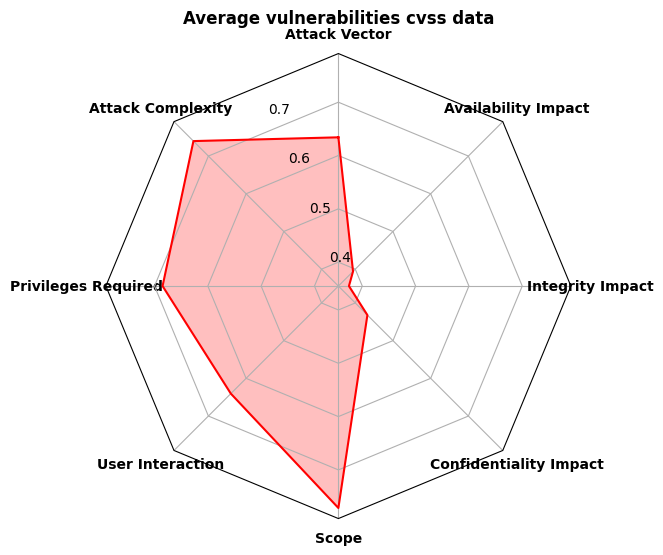

In [24]:
radial_chart_cves_version3()

In [35]:
def get_total_vulnerabilities():
    pipeline = [
        {
            "$project": {
                "_id": 0,
                "listSize": { "$size": "$vulnerabilities" }
            }
        },
        {
            "$match": {
                "listSize": { "$ne": 0 }
            }
        }
    ]
    
    softwares_vuln = list(softwares_clt.aggregate(pipeline))
    total_vulnerabilities = sum(doc['listSize'] for doc in softwares_vuln)
    return total_vulnerabilities


In [36]:
get_total_vulnerabilities()

296